In [1]:

import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
df = pd.read_csv('/content/drive/MyDrive/movieDSet/rating.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


In [6]:
df.userId.nunique()
df.movieId.nunique()

26744

In [7]:
df.rating.value_counts()

rating
4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: count, dtype: int64

In [8]:
df.shape

(20000263, 4)

In [9]:
class MovieDataset:

   def __init__(self, users, movies, ratings):

     self.users = users
     self.movies= movies
     self.ratings= ratings

   def __len__(self):
     return len(self.users)

   def __getitem__(self, item):

      users = self.users[item]

      movies=self.movies[item]

      ratings = self.ratings[item]
      return {
         "users":torch.tensor(users, dtype=torch.long),
        "movies":torch.tensor(movies, dtype=torch.long),
        "ratings":torch.tensor(ratings, dtype=torch.long)}


In [10]:
class RecSysModel(nn.Module):

  def __init__(self, n_users, n_movies):
    super().__init__()

    #trainable lookup matrix for shallow embedding vectors
    self.user_embed= nn.Embedding(n_users, 32)
    self.movie_embed= nn.Embedding (n_movies, 32)

    #user, movie embedding concat
    self.out = nn.Linear(64, 1)

  def forward(self, users, movies, ratings=None):
    user_embeds = self.user_embed(users)
    movie_embeds = self.movie_embed(movies)
    output = torch.cat([user_embeds, movie_embeds], dim=1)

    output = self.out(output)

    return output

In [11]:
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.2, random_state=42, stratify=df.rating.values
)

train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True, num_workers=2)

dataiter = iter(train_loader)
dataloader_data= next(dataiter)
print(dataloader_data)

{'users': tensor([125793,  26312,   5729,  42304,  78320, 108970,  84782,  15497,  14407,
         67550,  24467, 130870,  43248,  69303, 122065, 112132,  40743, 101907,
        112431,  92116,  70449,   1105,  74418, 112344,  56342,  26276,  38440,
         34123, 119207, 109269, 116525,  21713,  91612,  78194,  52622,  62002,
         29397,  42365,  34543,  21185, 123982,  25736,  41833,  72084,   1536,
         27221,  47576,  19357,  44228,  30293, 101028, 137254, 133988, 120784,
         47499,  26527,  16084,  25825,  26116,  59192,  92320,  43117,  70998,
         35161]), 'movies': tensor([16429,  1893,  2943,  6429,  1312,  4293,  2428,  4680,  3487,   912,
         3594,    23,  3702,  1237,  1839,  4132,   304,   360,  1313,  1172,
         3533,  9932,    57,   325,   338,  3091,  1997, 10492,   284, 11046,
         1625,  2001,  1471,  4696,  2772, 10678,   269,  4293,  2250,  5185,
         1588,  6765,   278,  1162,  2919,  3444,   820,  2006,  2880,   167,
        1485

In [13]:
model = RecSysModel(n_users=len(lbl_user.classes_), n_movies=len(lbl_movie.classes_))
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_fn = nn.MSELoss()

In [14]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

138493
26744
26743
16000210


In [15]:
#manually run a forward path
print(dataloader_data['users'])
print(dataloader_data['users'].size())
print(dataloader_data['movies'])
print(dataloader_data['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)

out = nn.Linear(64, 1)

tensor([125793,  26312,   5729,  42304,  78320, 108970,  84782,  15497,  14407,
         67550,  24467, 130870,  43248,  69303, 122065, 112132,  40743, 101907,
        112431,  92116,  70449,   1105,  74418, 112344,  56342,  26276,  38440,
         34123, 119207, 109269, 116525,  21713,  91612,  78194,  52622,  62002,
         29397,  42365,  34543,  21185, 123982,  25736,  41833,  72084,   1536,
         27221,  47576,  19357,  44228,  30293, 101028, 137254, 133988, 120784,
         47499,  26527,  16084,  25825,  26116,  59192,  92320,  43117,  70998,
         35161])
torch.Size([64])
tensor([16429,  1893,  2943,  6429,  1312,  4293,  2428,  4680,  3487,   912,
         3594,    23,  3702,  1237,  1839,  4132,   304,   360,  1313,  1172,
         3533,  9932,    57,   325,   338,  3091,  1997, 10492,   284, 11046,
         1625,  2001,  1471,  4696,  2772, 10678,   269,  4293,  2250,  5185,
         1588,  6765,   278,  1162,  2919,  3444,   820,  2006,  2880,   167,
        14859, 1

In [16]:
user_embeds = user_embed(dataloader_data['users'])
print(user_embeds)
print(user_embeds.size())
movie_embeds = movie_embed(dataloader_data['movies'])
print(movie_embeds)
print(movie_embeds.size())

tensor([[-0.9824, -1.5921,  2.0463,  ..., -0.8032,  1.0317,  2.4210],
        [-0.0615,  0.3193, -1.0971,  ..., -0.3558, -0.6986, -0.1235],
        [ 1.8972, -1.0902, -1.2527,  ...,  0.0387,  0.0861, -0.8797],
        ...,
        [-0.4657,  0.9892, -0.8814,  ...,  0.5000,  0.2852,  1.1007],
        [-0.5764, -0.9693, -0.2858,  ...,  0.0275, -0.2109, -0.7365],
        [-0.0256,  1.6377, -1.9710,  ...,  0.0698, -0.1006,  1.2263]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([64, 32])
tensor([[-1.1018,  0.7342, -0.3408,  ...,  1.1158,  1.6408,  1.8529],
        [ 1.7163,  1.5237, -0.2692,  ..., -0.1796, -1.7118,  0.8885],
        [-2.2188, -0.2542, -0.0873,  ..., -0.3847,  1.0337, -0.7485],
        ...,
        [ 1.2514, -0.5435, -0.4607,  ..., -0.0507,  0.3492,  0.0197],
        [ 0.2235,  0.0582,  2.6463,  ...,  2.0612,  0.2238, -0.6028],
        [-0.2901, -0.1073,  0.1664,  ..., -0.2813, -0.3105, -2.4803]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([64, 32])


In [17]:
output = torch.cat([user_embeds, movie_embeds], dim=1)
print(f"output : {output.size()}")
print(f"output : {output}")

output = out(output)
print(f"output : {output}")

output : torch.Size([64, 64])
output : tensor([[-0.9824, -1.5921,  2.0463,  ...,  1.1158,  1.6408,  1.8529],
        [-0.0615,  0.3193, -1.0971,  ..., -0.1796, -1.7118,  0.8885],
        [ 1.8972, -1.0902, -1.2527,  ..., -0.3847,  1.0337, -0.7485],
        ...,
        [-0.4657,  0.9892, -0.8814,  ..., -0.0507,  0.3492,  0.0197],
        [-0.5764, -0.9693, -0.2858,  ...,  2.0612,  0.2238, -0.6028],
        [-0.0256,  1.6377, -1.9710,  ..., -0.2813, -0.3105, -2.4803]],
       grad_fn=<CatBackward0>)
output : tensor([[-0.6006],
        [ 0.2273],
        [-0.5170],
        [-0.3046],
        [-0.0147],
        [ 0.9191],
        [ 0.5897],
        [ 0.0796],
        [ 0.2777],
        [ 0.2807],
        [ 0.3829],
        [ 1.3123],
        [ 0.8256],
        [-0.6063],
        [ 0.6826],
        [ 0.0589],
        [ 0.3335],
        [ 1.3042],
        [ 1.3959],
        [-0.2057],
        [-0.6414],
        [-0.9585],
        [ 0.2743],
        [-0.1911],
        [ 0.1128],
        [ 0.

In [18]:
with torch.no_grad():
  # Ensure both input tensors are on the same device as the model
  users = dataloader_data['users'].to(next(model.parameters()).device)
  movies = dataloader_data['movies'].to(next(model.parameters()).device)

  model_output = model(users, movies)
  print(model_output)
  print(model_output.size())

tensor([[ 0.2023],
        [ 0.0183],
        [ 0.5722],
        [ 0.6575],
        [-0.2268],
        [-0.3847],
        [-0.1063],
        [ 0.1130],
        [-0.1602],
        [-0.6775],
        [ 0.2876],
        [-0.2204],
        [ 0.5658],
        [ 0.2906],
        [-0.2184],
        [-0.7494],
        [ 0.2042],
        [-0.2017],
        [ 0.1530],
        [-0.2588],
        [-0.3843],
        [-0.8244],
        [ 1.4113],
        [ 0.2380],
        [ 0.1397],
        [ 0.2398],
        [-0.4712],
        [ 0.5455],
        [-0.2275],
        [ 0.6328],
        [-0.0027],
        [-0.2154],
        [-1.1335],
        [ 0.4113],
        [ 0.3382],
        [-1.1151],
        [-0.4587],
        [ 0.1767],
        [ 0.1544],
        [-1.1243],
        [ 0.3144],
        [ 0.0204],
        [ 0.3253],
        [-0.2572],
        [-0.4782],
        [-0.0400],
        [-0.9319],
        [ 0.2253],
        [ 0.0731],
        [ 0.0297],
        [-0.4340],
        [-0.0466],
        [ 0.

In [19]:
rating = dataloader_data['ratings']
print(rating)
print(rating.view(4,-1))
print(model_output)

print(rating.sum())
print(model_output.sum() - rating.sum())

tensor([4, 4, 4, 4, 5, 2, 1, 4, 5, 3, 3, 3, 3, 4, 5, 5, 3, 5, 4, 4, 3, 3, 5, 4,
        2, 3, 5, 3, 4, 4, 4, 3, 4, 4, 4, 3, 3, 3, 1, 3, 2, 2, 4, 3, 5, 4, 4, 4,
        4, 3, 3, 2, 4, 3, 4, 3, 4, 3, 5, 5, 4, 5, 4, 5])
tensor([[4, 4, 4, 4, 5, 2, 1, 4, 5, 3, 3, 3, 3, 4, 5, 5],
        [3, 5, 4, 4, 3, 3, 5, 4, 2, 3, 5, 3, 4, 4, 4, 3],
        [4, 4, 4, 3, 3, 3, 1, 3, 2, 2, 4, 3, 5, 4, 4, 4],
        [4, 3, 3, 2, 4, 3, 4, 3, 4, 3, 5, 5, 4, 5, 4, 5]])
tensor([[ 0.2023],
        [ 0.0183],
        [ 0.5722],
        [ 0.6575],
        [-0.2268],
        [-0.3847],
        [-0.1063],
        [ 0.1130],
        [-0.1602],
        [-0.6775],
        [ 0.2876],
        [-0.2204],
        [ 0.5658],
        [ 0.2906],
        [-0.2184],
        [-0.7494],
        [ 0.2042],
        [-0.2017],
        [ 0.1530],
        [-0.2588],
        [-0.3843],
        [-0.8244],
        [ 1.4113],
        [ 0.2380],
        [ 0.1397],
        [ 0.2398],
        [-0.4712],
        [ 0.5455],
        [-0.2275],

In [20]:
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000 , 5000
step_cnt= 0
all_loses_list = []

loss_func = nn.MSELoss()

model.train()
for epoch_i in range(epochs):
  for i, train_data in enumerate(train_loader):
    # Move input tensors to the same device as the model
    users = train_data['users'].to(next(model.parameters()).device)
    movies = train_data['movies'].to(next(model.parameters()).device)

    output = model(users, movies)

    rating = train_data["ratings"].view(output.size(0), -1).to(torch.float32).to(next(model.parameters()).device)  # Move ratings to the correct device


    loss = loss_func(output, rating)
    total_loss += loss.sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    step_cnt = step_cnt + len(train_data["users"])

    if(step_cnt % plot_steps== 0):
      avg_loss = total_loss/(len(train_data["users"])*plot_steps)
      print(f"epoch : {epoch_i} loss at step : {step_cnt} is : {avg_loss}")
      all_loses_list.append(avg_loss)
      total_loss = 0

epoch : 0 loss at step : 40000 is : 0.021030060788989068
epoch : 0 loss at step : 80000 is : 0.010221710308641196
epoch : 0 loss at step : 120000 is : 0.005829993299394846
epoch : 0 loss at step : 160000 is : 0.004168457517027855
epoch : 0 loss at step : 200000 is : 0.003253915798664093
epoch : 0 loss at step : 240000 is : 0.0027913544453680517
epoch : 0 loss at step : 280000 is : 0.0025297024205327033
epoch : 0 loss at step : 320000 is : 0.002338928960636258
epoch : 0 loss at step : 360000 is : 0.0021961818682029845
epoch : 0 loss at step : 400000 is : 0.002125527175888419
epoch : 0 loss at step : 440000 is : 0.0020878675336018205
epoch : 0 loss at step : 480000 is : 0.0020281932586804032
epoch : 0 loss at step : 520000 is : 0.0020573625437915327
epoch : 0 loss at step : 560000 is : 0.0020195210875943305
epoch : 0 loss at step : 600000 is : 0.0019805895356461408
epoch : 0 loss at step : 640000 is : 0.001966074580512941
epoch : 0 loss at step : 680000 is : 0.0020021303502842785
epoch :

<function matplotlib.pyplot.show(close=None, block=None)>

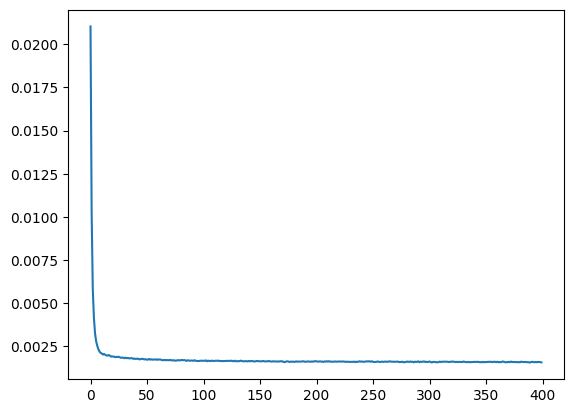

In [21]:
plt.figure()
plt.plot(all_loses_list)
plt.show

In [22]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()



with torch.no_grad():
  for i, batched_data in enumerate(valid_loader):
    users = batched_data['users'].to(next(model.parameters()).device)
    movies = batched_data['movies'].to(next(model.parameters()).device)

    model_output = model(users, movies)
    model_output_list.append(model_output.sum().item() / len(batched_data["users"]))

    target_rating = batched_data['ratings']
    target_rating_list.append(batched_data['ratings'].sum().item() / len(batched_data["users"]))

    print(f"model output : {model_output}")
    print(f"target rating : {target_rating}")

rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(rms)

Streaming output truncated to the last 5000 lines.
        [2.8566],
        [2.7915],
        [3.1709],
        [3.8136],
        [2.9133],
        [4.7863],
        [4.1726],
        [3.2106],
        [3.9898],
        [3.2044],
        [3.5159],
        [3.7795],
        [4.4023],
        [3.6212],
        [2.9720],
        [3.7618],
        [1.5750],
        [2.8483],
        [3.7333],
        [3.9863],
        [2.8936],
        [3.9343],
        [3.1548],
        [3.4715],
        [4.1402],
        [3.4829],
        [2.6804],
        [3.8780],
        [2.4333],
        [4.0244],
        [3.0018],
        [3.1875],
        [2.8466],
        [3.2487],
        [2.9599],
        [3.3937],
        [3.6304],
        [1.6675],
        [3.4615],
        [2.9187],
        [2.9499],
        [2.4428],
        [2.5617],
        [3.2886],
        [2.5067],
        [3.8628],
        [4.2809],
        [3.5815],
        [3.8800]])
target rating : tensor([4, 4, 4, 5, 1, 5, 3, 4, 5, 3, 5, 5, 5, 3, 

In [23]:
from collections import defaultdict

user_est_true = defaultdict(list)

with torch.no_grad():
  for i, batched_data in enumerate(valid_loader):
    users= batched_data['users'].to(next(model.parameters()).device)
    movies = batched_data['movies'].to(next(model.parameters()).device)
    ratings = batched_data['ratings']
    model_output = model(users, movies)

    for i in range(len(users)):
      user_id= users[i].item()
      movie_id = movies[i].item()
      pred_rating= model_output[i][0].item()
      true_rating = ratings[i].item()

      print(f"user : {user_id} movie : {movie_id} pred_rating : {pred_rating} true_rating : {true_rating}")
      user_est_true[user_id].append((movie_id, true_rating))


Streaming output truncated to the last 5000 lines.
user : 58135 movie : 887 pred_rating : 4.58568811416626 true_rating : 5
user : 43062 movie : 1230 pred_rating : 3.9208569526672363 true_rating : 4
user : 17974 movie : 490 pred_rating : 3.208242893218994 true_rating : 3
user : 109553 movie : 15275 pred_rating : 3.935242176055908 true_rating : 3
user : 103063 movie : 2203 pred_rating : 3.534658432006836 true_rating : 4
user : 2186 movie : 325 pred_rating : 3.0692789554595947 true_rating : 2
user : 58611 movie : 4933 pred_rating : 2.470855474472046 true_rating : 1
user : 88101 movie : 51 pred_rating : 3.466362953186035 true_rating : 5
user : 13563 movie : 1207 pred_rating : 4.124452590942383 true_rating : 4
user : 138185 movie : 8274 pred_rating : 3.395707607269287 true_rating : 3
user : 82244 movie : 1346 pred_rating : 3.207679033279419 true_rating : 3
user : 89329 movie : 785 pred_rating : 2.1131653785705566 true_rating : 3
user : 17996 movie : 151 pred_rating : 3.3554511070251465 true

In [24]:
with torch.no_grad():
  precisions = dict()
  recalls = dict()

  k=100
  threshold = 3.5

  for uid, user_ratings in user_est_true.items():
    user_ratings.sort(key=lambda x: x[0], reverse=True)

    n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

    n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

    n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                          for (est, true_r) in user_ratings[:k])

    print(f"uid : {uid} n_rel : {n_rel} n_rec_k : {n_rec_k} n_rel_and_rec_k : {n_rel_and_rec_k}")

    precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

Streaming output truncated to the last 5000 lines.
uid : 104133 n_rel : 4 n_rec_k : 5 n_rel_and_rec_k : 4
uid : 44416 n_rel : 1 n_rec_k : 3 n_rel_and_rec_k : 1
uid : 45214 n_rel : 5 n_rec_k : 7 n_rel_and_rec_k : 5
uid : 125440 n_rel : 5 n_rec_k : 8 n_rel_and_rec_k : 5
uid : 84959 n_rel : 9 n_rec_k : 9 n_rel_and_rec_k : 9
uid : 61039 n_rel : 2 n_rec_k : 7 n_rel_and_rec_k : 2
uid : 109511 n_rel : 5 n_rec_k : 7 n_rel_and_rec_k : 5
uid : 132262 n_rel : 1 n_rec_k : 2 n_rel_and_rec_k : 1
uid : 115636 n_rel : 6 n_rec_k : 8 n_rel_and_rec_k : 6
uid : 7572 n_rel : 4 n_rec_k : 15 n_rel_and_rec_k : 4
uid : 96448 n_rel : 5 n_rec_k : 6 n_rel_and_rec_k : 5
uid : 111132 n_rel : 2 n_rec_k : 4 n_rel_and_rec_k : 2
uid : 1610 n_rel : 2 n_rec_k : 5 n_rel_and_rec_k : 2
uid : 20172 n_rel : 2 n_rec_k : 2 n_rel_and_rec_k : 2
uid : 45177 n_rel : 3 n_rec_k : 6 n_rel_and_rec_k : 3
uid : 16057 n_rel : 6 n_rec_k : 7 n_rel_and_rec_k : 6
uid : 103523 n_rel : 4 n_rec_k : 7 n_rel_and_rec_k : 4
uid : 79333 n_rel : 2 n_r

In [25]:
print(f"precision @ {k} : {sum(prec for prec in precisions.values()) / len(precisions)}")
print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")

precision @ 100 : 0.548643389167866
recall @ 100 : 0.9742899103450994
